In [1]:
import numpy as np
import scipy.integrate
import scipy.interpolate
%matplotlib inline
import matplotlib as mpl, matplotlib.pyplot as plt
import glob
import operator as op

from __future__ import print_function, division

mpl.rc('font', size=18)
mpl.rc('figure', figsize=(12,6))

In [2]:
# convert a string representation of a number
# of the sort produced by spherical_cloudy
# back into a numerical value, by replacing:
#     'd' with '.'
#     'p' with '+'
#     'n' with '-'
def deformat_string(s):
    return s.replace('d', '.').replace('p', '+').replace('m', '-')

ions = ['H I', 'D I', 'He I', 'He II']
nions = len(ions)

sph_cloudy_dtype = ([('rad', 'float64'), # radius
           ('temp', 'float64'),          # temperature
           ('hden', 'float64'),          # HI volume density
           ('HaSB', 'float64'),          # surface brightness in H-alpha
           ('tden', 'float64', nions),   # volume density for each species
           ('cden', 'float64', nions)])  # column density for each species

class SphCloudyResult:
    def __init__(self, fname):
        self.fname = fname
        self.data = np.load(fname)
        self.data.dtype = sph_cloudy_dtype
        
        # parse the file name to extract model parameters
        self.params = dict()
        end_of_rel_path = fname.rfind('/') + 1
        fname_parts = fname[end_of_rel_path:].split('_')
        for part in fname_parts:
            if(part == 'NFW'):
                self.params['profile'] = 'NFW'
            elif part.startswith('mass'):
                mass_str = deformat_string(part[4:])
                self.params['mass'] = float(mass_str)
            elif part.startswith('redshift'):
                z_str = deformat_string(part[8:])
                self.params['redshift'] = float(z_str)
            elif part.startswith('baryscl'):
                bary_str = deformat_string(part[7:])
                self.params['bary_scl'] = float(bary_str)
            elif part.startswith('HMscale'):
                He_str = deformat_string(part[7:])
                self.params['HM_scl'] = float(He_str)
            else:
                # remaining part is nrad_nmu (.npy)
                nrad, nmu = (part.rstrip('.npy').split('-'))
                self.params['n_rad'] = nrad
                self.params['nmu'] = nmu

In [22]:
sph_cloudy_files = glob.glob('./data/NFW*.npy')
sph_cloudy_data = [SphCloudyResult(f) for f in sph_cloudy_files]

def compose(f, g):
    return lambda x: f(g(x))

sorted_by_mass = sorted(sph_cloudy_data, key=compose(op.itemgetter('mass'),op.attrgetter('params')))
sph_cloudy_masses = np.array(list(map(compose(op.itemgetter('mass'),op.attrgetter('params')), sorted_by_mass)))
sph_cloudy_radii = np.array([res.data['rad'] for res in sorted_by_mass]).squeeze()
sph_cloudy_lognh = np.log10([res.data['hden'] for res in sorted_by_mass]).squeeze()

In [29]:
fname_ext = '.dat'
fname_base = 'rhos_gas_eagle'
fname_rho = fname_base + fname_ext
fname_M = fname_base + '_masses' + fname_ext
fname_Rv = fname_base + '_Rvirs' + fname_ext
masses = np.loadtxt(fname_M)
rtws, rhos_gas = np.hsplit(np.loadtxt(fname_rho), [1])
R200s = np.loadtxt(fname_Rv).flatten()
rtws = rtws.flatten()
rhos_gas = rhos_gas.T

cm_per_kpc = 3e10 * 86400 * 365 * 3.26 * 1000
mp = 1.673e-24

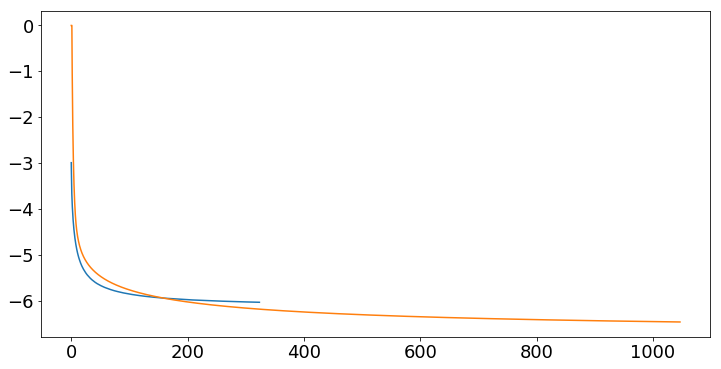

In [30]:
idx = 19

plt.figure()
plt.plot(sph_cloudy_radii[idx] / 1000, sph_cloudy_lognh[idx])
plt.plot(rtws * R200s[idx] / cm_per_kpc, np.log10(rhos_gas[idx] / mp))